<a href="https://colab.research.google.com/github/MariiaKalinina/BM/blob/main/Basin_worked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [303]:
import pandas as pd
import numpy as np
from math import *
from scipy.special import lambertw
import matplotlib.pyplot as plt

In [304]:
!pip install GitPython

In [305]:
from git import Repo
!git clone https://github.com/MariiaKalinina/BM.git

fatal: destination path 'BM' already exists and is not an empty directory.


### Step 0. Data preparation

In [306]:
# import pandas as pd

df_constast = pd.read_csv('/content/BM/Constants.csv', delimiter=';', header=0)

df_well = pd.read_csv('/content/BM/Well_parametrs.csv', delimiter=';', header=0)
# df_well = pd.read_csv('/content/Well_parametrs_v1.csv', delimiter=';', header=0) ### пример для 3х слойной модели
df_well[['Depth top, m', 'Depth bottom, m']] = df_well[['Depth top, m', 'Depth bottom, m']].apply(lambda x: x / 1000)

In [307]:
df_well

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
0,Test_well,Erosion,Erosion,NaN,0,0.00,0.00,0,NaN,300,0,1,NaN,NaN,NaN,NaN
1,Test_well,Layer 10,Erosion,Shales,0,0.00,0.20,200,NaN,300,0,1,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstones,45,0.20,0.45,250,NaN,325,40,1,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shales,55,0.45,1.20,750,NaN,350,50,1,Reservoir,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk,80,1.20,2.50,1300,NaN,300,100,1,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstones,100,2.50,3.40,900,NaN,200,80,1,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestones,125,3.40,3.60,200,NaN,20,70,10,NaN,NaN,NaN,NaN
7,Test_well,Layer 4,Deposition,Dolomite,145,3.60,4.00,400,NaN,20,-40,1,Reservoir,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstones,160,4.00,4.25,250,NaN,10,-20,1,NaN,NaN,NaN,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,10,NaN,NaN,NaN,NaN


In [308]:
df_constast

,Lithology_type,Porosity,"Exp_decay, km-1",Grain density,TC matrix,Radiogenic Heat Production,Ki_framework
0,Shales,0.63,0.51,2720,2.0,1.700000e-06,2.0
1,Sandstones,0.49,0.27,2650,5.5,1.200000e-06,5.5
2,Chalk,0.70,0.71,2710,3.3,4.000000e-07,3.3
3,Limestones,0.40,0.60,2710,3.3,5.000000e-07,3.3
4,Dolomite,0.20,0.60,2870,5.3,4.000000e-07,5.3
5,Anhydrite,0.05,0.20,2960,6.3,1.000000e-07,6.3
6,Quartzite,0.20,0.30,2650,7.7,5.000000e-07,7.7
7,Fundament,0.00,0.00,2800,3.0,2.800000e-06,3.0


In [309]:

### Кол-во слоев по которым будет проходит расчет.
### Не учитывает первый слой - Эрозию и последний - Фундамент
layers_quantity = len(df_well[1:df_well.shape[0]-1]) #amount of layers for calculation
layers_quantity

10

In [362]:
work_layers = df_well[1:df_well.shape[0]-1] ### Слои, по которым идет расчет
work_layers

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
1,Test_well,Layer 10,Erosion,Shales,0,0.00,0.20,200,NaN,300,0,1,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstones,45,0.20,0.45,250,NaN,325,40,1,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shales,55,0.45,1.20,750,NaN,350,50,1,Reservoir,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk,80,1.20,2.50,1300,NaN,300,100,1,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstones,100,2.50,3.40,900,NaN,200,80,1,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestones,125,3.40,3.60,200,NaN,20,70,10,NaN,NaN,NaN,NaN
7,Test_well,Layer 4,Deposition,Dolomite,145,3.60,4.00,400,NaN,20,-40,1,Reservoir,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstones,160,4.00,4.25,250,NaN,10,-20,1,NaN,NaN,NaN,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,10,NaN,NaN,NaN,NaN
10,Test_well,Layer 1,Deposition,Quartzite,245,5.00,5.40,400,NaN,0,0,1,NaN,NaN,NaN,NaN


In [311]:

# filtered_df = df_well[df_well['Event_name'] != 'Erosion']

### Step 1, 2, 3

Step 1. Decompaction (decompacted thickness).

Step 2. Correction for paleobathymetry and eustasy (Decompacted depth with corrction).

Step 3. Removal effect of sediment load (porosity, density).



In [312]:
def decomp_func(y1, y2, y1_d, phi, c):  # возвращает фун-ию одной переменной, для которой затем подбирается параметр y2_d

    y2_d = (np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) - \
            np.exp(-np.log(e) * y1 * c) * phi * np.log(e) + \
            np.exp(-np.log(e) * y2 * c) * phi * np.log(e) - \
            np.log(e) * y1 * c + np.log(e) * y1_d * c + np.log(e) * y2 * c + \
            lambertw(-np.log(e) * phi * np.exp(-np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) +\
                                               np.exp(-np.log(e) * y1 * c) * phi * np.log(e) - \
                                               np.exp(-np.log(e) * y2 * c) * phi * np.log(e) + \
                                               np.log(e) * y1 * c - \
                                               np.log(e) * y1_d * c - np.log(e) * y2 * c))) / c / np.log(e)
    return y2_d.real

In [313]:
#считает скорректированную декомпактированную глубину
def corrected(depth, RoMantle, RoWater, sea_level, sea_level_today):
  return depth - sea_level_today * (RoWater / (RoMantle - RoWater)) + (sea_level - sea_level_today)

In [314]:
### the averaeg porosity of a stratigraphic unit at any depth [A.58.6]
def porosity_func(surface_porosity, exp_decay, y1, y2, thicknesses):
  return surface_porosity/exp_decay*((np.exp(-exp_decay*y1) - np.exp(-exp_decay*y2))/thicknesses)

In [315]:

def bulk_density(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [316]:
def bulk_density_column(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [317]:
def tectonic_subsidence (RoMantle, RoWater, RoColumn, depth):
  return depth*((RoMantle-RoColumn)/(RoMantle-RoWater))

In [318]:

# decompaction_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.3

# age = list(df_well['Age (Ma)'][1:])

# for i, a in enumerate(age, start=0):
#     print('Age', a)

#     work_layers_copy = work_layers.copy()
#     rows_to_delete = []
#     thinkness_list = []

#     for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

#       lithology = work_layers_copy.at[row.Index, 'Lithology_type']
#       layers_name = work_layers_copy.at[row.Index, 'Event_name']

#       if row_index == i: #<--- если первый слов, то y1 decompaced = 0
#         y1_d = 0

#       else:
#         y1_d = y2_d

#       phi0 = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Porosity'].iloc[0]
#       c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
#       y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
#       y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

#       y2_d = decomp_func(y1, y2, y1_d, phi0, c)

#       thicknesses = np.round(y2_d - y1_d, 3) #A58.3
#       thinkness_list.append(thicknesses)

#       print(row_index, lithology, layers_name, thicknesses)
#     print(sum(thinkness_list), end='\n\n')

#     ### Save result in table
#     resized_list = np.zeros(10)
#     resized_list[:len(thinkness_list)] = thinkness_list

#     new_col_values = resized_list[::-1]
#     new_col_name = f'{a} Ma'
#     decompaction_df[new_col_name] = new_col_values

In [319]:
decompaction_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.3
decompaction_corrected_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.4
porosity_df = pd.DataFrame() ### <-- Porosities as a function of time for 10 lithological units undergoing progressive compaction during burial.
                            ### Table A58.4
density_df = pd.DataFrame()
density_column_df = pd.DataFrame()

age_list = list(df_well['Age (Ma)'][1:])

for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    thinkness_list = []
    thinkness_corrected_list = []
    porosity_average_list = []
    porosity_test = []
    density_list = []
    density_column = []
    density_column_total = []

    RoWater, RoMantle = 1000, 3300
    sea_level = df_well.loc[df_well['Age (Ma)'] == int(age), 'Paleobathymetry, Ma'].iloc[0]/1000
    sea_level_today = df_well.loc[df_well['Age (Ma)'] == int(age), 'Sea level, m'].iloc[0]/1000

    print('Age', age)

### расчет corrected_decompaction for Fundament (not in work_layer)
    if int(age) == age_list[-1]:
          depth = 0
          y2_d_corrected = abs(np.round(corrected(depth, RoMantle, RoWater, sea_level, sea_level_today), 3))
          thinkness_corrected_list.append(y2_d_corrected)

### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      phi0 = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Porosity'].iloc[0]
      c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
      RoGrain = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Grain density'].iloc[0]
      y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]


      if row_index == i: #<--- если первый слов, то y1 decompaced = 0
        y1_d = 0
        if age == 0:
          pass
        else:
          y1_d_corrected = corrected(y1_d, RoMantle, RoWater, sea_level, sea_level_today)
          thinkness_corrected_list.append(y1_d_corrected)

      else:
        y1_d = y2_d
        y1_d_corrected = y2_d_corrected
### decompaction depth
      y2_d = decomp_func(y1, y2, y1_d, phi0, c)
      thicknesses = y2_d - y1_d #A58.3
      thinkness_list.append(np.round(thicknesses, 3))
### corrected decompaction depth
      y2_d_corrected = corrected(y2_d, RoMantle, RoWater, sea_level, sea_level_today)
      thinkness_corrected_list.append(y2_d_corrected)
### porosity
      porosity = np.round(porosity_func(phi0, c, y1_d, y2_d, thicknesses), 3)
      porosity_average_list.append(np.round(porosity, 3))

### Density
      density = bulk_density(porosity, RoGrain, RoWater)
      density_list.append(int(np.round(density, 2)))

      print(row_index, lithology, layers_name, phi0, c, density)

### Density of entire sediment column [A58.5]
      a = (porosity*RoWater + (1-porosity)*RoGrain)*thicknesses
      density_column.append(a)

    if int(age) == age_list[-1]:
      pass
      density_col = 0
      density_column_total.append(density_col)
    else:
      density_col = sum(density_column)/sum(thinkness_list)
      density_column_total.append(np.round(density_col, 3))
      print(sum(thinkness_list), density_col, end='\n\n')

# for por, RoGrian in zip(porosity_average_list, )

 ### Save results in table
    new_col_name = f'{age}'

    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(thinkness_list):] = thinkness_list


    # resized_list = np.zeros(work_layers_copy.shape[0])
    # resized_list[:len(thinkness_list)] = thinkness_list

    new_col_values = resized_list_new
    decompaction_df[new_col_name] = new_col_values

    ### Save result for corrected decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(thinkness_corrected_list):] = thinkness_corrected_list

    new_col_values_new = resized_list_new
    decompaction_corrected_df[new_col_name] = new_col_values_new

    ### Save result for average porosity in table
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(porosity_average_list):] = porosity_average_list
    new_col_values = resized_list
    porosity_df[new_col_name] = new_col_values

### Save result for the bulk density in table
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(density_list):] = density_list
    new_col_values = resized_list
    density_df[new_col_name] = new_col_values

### Save result for the bulk density of column
    density_column_df[new_col_name] = density_column_total



Age 0
0 Shales Layer 10 0.63 0.51 1689.72
1 Sandstones Layer 9 0.49 0.27 1909.1499999999999
2 Shales Layer 8 0.63 0.51 2004.4800000000002
3 Chalk Layer 7 0.7 0.71 2376.5499999999997
4 Sandstones Layer 6 0.49 0.27 2285.35
5 Limestones Layer 5 0.4 0.6 2626.21
6 Dolomite Layer 4 0.2 0.6 2830.73
7 Sandstones Layer 3 0.49 0.27 2384.35
8 Anhydrite Layer 2 0.05 0.2 2920.7999999999997
9 Quartzite Layer 1 0.2 0.3 2580.7
5.4 2396.5598148148147

Age 45
1 Sandstones Layer 9 0.49 0.27 1869.55
2 Shales Layer 8 0.63 0.51 1940.84
3 Chalk Layer 7 0.7 0.71 2345.77
4 Sandstones Layer 6 0.49 0.27 2273.8
5 Limestones Layer 5 0.4 0.6 2621.08
6 Dolomite Layer 4 0.2 0.6 2828.86
7 Sandstones Layer 3 0.49 0.27 2377.75
8 Anhydrite Layer 2 0.05 0.2 2920.7999999999997
9 Quartzite Layer 1 0.2 0.3 2579.0499999999997
5.3020000000000005 2396.44111964442

Age 55
2 Shales Layer 8 0.63 0.51 1847.96
3 Chalk Layer 7 0.7 0.71 2303.02
4 Sandstones Layer 6 0.49 0.27 2260.6000000000004
5 Limestones Layer 5 0.4 0.6 2614.24
6 Do

In [320]:
# density_column_df

In [321]:
decompaction_df.loc['Stratigraphic thickness (km)', :] = decompaction_df.sum(axis=0) # <-- ввод общией мощности

### добавление колонок Lithology_typeб	Event_name
work_layers.reset_index(drop=True, inplace=True)
decompaction_df['Event_name'] = work_layers['Event_name']
decompaction_df['Lithology_type'] = work_layers['Lithology_type']
decompaction_df = decompaction_df[decompaction_df.columns[::-1]]

decompaction_df.to_csv('/content/Decompaction.csv', index=True)

In [322]:
### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
decompaction_corrected_df['Event_name'] = work_layers['Event_name']
decompaction_corrected_df['Lithology_type'] = work_layers['Lithology_type']
decompaction_corrected_df = decompaction_corrected_df[decompaction_corrected_df.columns[::-1]]

decompaction_corrected_df.to_csv('/content/Decompaction_corrected.csv', index=True)

In [323]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
porosity_df['Event_name'] = work_layers['Event_name']
porosity_df['Lithology_type'] = work_layers['Lithology_type']
porosity_df = porosity_df[porosity_df.columns[::-1]]

porosity_df.to_csv('/content/Porosity.csv', index=True)

In [324]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
density_df['Event_name'] = work_layers['Event_name']
density_df['Lithology_type'] = work_layers['Lithology_type']
density_df = density_df[density_df.columns[::-1]]

density_df.to_csv('/content/Density.csv', index=True)

In [325]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
density_column_df['Event_name'] = work_layers['Event_name']
density_column_df['Lithology_type'] = work_layers['Lithology_type']
density_column_df = density_column_df[density_column_df.columns[::-1]]

density_column_df.to_csv('/content/Density_column.csv', index=True)

In [326]:
density_column_df

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0,2341.609,2698.397,2509.874,2553.82,2518.031,2392.816,2357.993,2383.389,2396.441,2396.56


In [327]:
decompaction_corrected_df

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.267609,0.50
1,Sandstones,Layer 9,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.278261,0.529083,0.75
2,Shales,Layer 8,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.156522,1.165901,1.329189,1.50
3,Chalk,Layer 7,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085217,1.903843,2.539444,2.659257,2.80
4,Sandstones,Layer 6,0.000,0.000000,0.000000,0.000000,0.000000,-0.080435,1.289725,2.862782,3.456213,3.566666,3.70
5,Limestones,Layer 5,0.000,0.000000,0.000000,0.000000,0.077391,0.219591,1.522028,3.068223,3.657687,3.767310,3.90
6,Dolomite,Layer 4,0.000,0.000000,0.000000,0.038696,0.551755,0.678387,1.945401,3.472535,4.058873,4.167828,4.30
7,Sandstones,Layer 3,0.000,0.000000,0.020000,0.430762,0.907915,1.017546,2.238826,3.732569,4.311812,4.419136,4.55
8,Anhydrite,Layer 2,0.000,0.000000,0.790834,1.198791,1.673076,1.781086,2.996802,4.484763,5.062484,5.169437,5.30
9,Quartzite,Layer 1,0.034,0.471032,1.240818,1.640374,2.106633,2.210350,3.412623,4.888709,5.463658,5.569962,5.70


In [328]:
porosity_df

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.599
1,Sandstones,Layer 9,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.473,0.449
2,Shales,Layer 8,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.507,0.453,0.416
3,Chalk,Layer 7,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.401,0.238,0.213,0.195
4,Sandstones,Layer 6,0.0,0.000,0.000,0.000,0.000,0.000,0.418,0.269,0.236,0.228,0.221
5,Limestones,Layer 5,0.0,0.000,0.000,0.000,0.000,0.366,0.181,0.074,0.056,0.052,0.049
6,Dolomite,Layer 4,0.0,0.000,0.000,0.000,0.174,0.146,0.075,0.031,0.023,0.022,0.021
7,Sandstones,Layer 3,0.0,0.000,0.000,0.465,0.411,0.381,0.285,0.193,0.171,0.165,0.161
8,Anhydrite,Layer 2,0.0,0.000,0.046,0.043,0.039,0.037,0.030,0.023,0.021,0.020,0.020
9,Quartzite,Layer 1,0.0,0.187,0.148,0.132,0.116,0.107,0.079,0.051,0.045,0.043,0.042


### Porosity - Depth plot

In [329]:
# Petromod

data_ref = pd.read_excel('/content/Charts (1).xlsx', sheet_name='Petromod por', skiprows=0, header=0, engine='openpyxl')
data_ref = data_ref.applymap(lambda x: x.split('\t') if isinstance(x, str) else x)

depth_dc, porosity_plot = [],[]

# Create a sample DataFrame with shape 10x2
depth_dc = decompaction_corrected_df['0'].tolist()
porosity_plot = data_ref[0].tolist()

data = {
    'porosity': porosity_plot,
    'depth_dc': depth_dc
}
df = pd.DataFrame(data)

# # Repeat each column in order like 1 cell, 1 cell, 2 cell, 2 cell, 3 cell, 3 cell
# new_data = {key: [val for val in df[key] for _ in range(2)] for key in df.columns}



# Rewrite the dictionary comprehension as a list comprehension
new_data_list = [(key, [val for val in df[key] for _ in range(2)]) for key in df.columns]
new_data_list[0][1].append(0)
new_data_list[1][1].insert(0, 0)

# Display the new_data_list
print(new_data_list[0][1])

# Convert the list of tuples to a dictionary
data_dict = {key: value for key, value in new_data_list}

# Create a DataFrame from the dictionary
new_df_ref = pd.DataFrame(data_dict)

[0.5992999999999999, 0.5992999999999999, 0.4499, 0.4499, 0.41229999999999994, 0.41229999999999994, 0.2012, 0.2012, 0.225, 0.225, 0.0489, 0.0489, 0.0215, 0.0215, 0.1645, 0.1645, 0.0209, 0.0209, 0.0444, 0.0444, 0]


In [330]:
# Calculated data

depth_dc, porosity_plot = [],[]

# Create a sample DataFrame with shape 10x2
depth_dc = decompaction_corrected_df['0'].tolist()
porosity_plot = porosity_df['0'].tolist()

data = {
    'porosity': porosity_plot,
    'depth_dc': depth_dc
}
df = pd.DataFrame(data)

# # Repeat each column in order like 1 cell, 1 cell, 2 cell, 2 cell, 3 cell, 3 cell
# new_data = {key: [val for val in df[key] for _ in range(2)] for key in df.columns}



# Rewrite the dictionary comprehension as a list comprehension
new_data_list = [(key, [val for val in df[key] for _ in range(2)]) for key in df.columns]
new_data_list[0][1].append(0)
new_data_list[1][1].insert(0, 0)

# Display the new_data_list
print(new_data_list[0][1])

# Convert the list of tuples to a dictionary
data_dict = {key: value for key, value in new_data_list}

# Create a DataFrame from the dictionary
new_df = pd.DataFrame(data_dict)

[0.599, 0.599, 0.449, 0.449, 0.416, 0.416, 0.195, 0.195, 0.221, 0.221, 0.049, 0.049, 0.021, 0.021, 0.161, 0.161, 0.02, 0.02, 0.042, 0.042, 0]


In [331]:
def makeplot_porosity(property, top_depth, bottom_depth):
    # fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    # ax = fig.subplots(1, 2,  sharex=False)

    fig, ax = plt.subplots(figsize=(14,7))

    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    # ax10 = ax1.twiny()
    # ax10.xaxis.set_visible(False)

    # ax13 = ax4.twiny()
    # ax13.xaxis.set_visible(False)

### Plot 1
    # Geotherma
    ax1.plot(new_df_ref['porosity'], new_df['depth_dc'], label='Petromod', color='red')
    ax1.plot(new_df['porosity'], new_df['depth_dc'], label='BM', color='black')
    ax1.set_xlabel(f'Porosity', labelpad=20)
    ax1.set_ylabel(f'Depth (km)')
    ax1.legend(loc='upper left')
    ax1.set_xlim(0, 0.6)

### Plot 2
    # Lithology track
    # ax2.plot(T_with_rad_heat["Lithology"], T_with_rad_heat['depth 0'], color = "black", linewidth = 0.5)
    ax2.set_xlabel("Lithology")
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(T_with_rad_heat["Lithology"], decompaction_corrected_df['0']):
        key = int(lit)
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']

        depth_values = [depth_start, depth]
        depth_start = depth

        ax2.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch)

    ax2.set_xticks([0, 1])

### Plot3
    ax3.set_xlabel("Lithology")
    ax3.set_xlim(0, 1)
    ax3.xaxis.label.set_color("black")
    ax3.tick_params(axis='x', colors="black")
    ax3.spines["top"].set_edgecolor("black")
    ax3.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(property["Lithology_type"], decompaction_corrected_df['0']):
        key = lit
        depth_values = [depth_start, depth]
        depth_start = depth

        label_position = (0.5, sum(depth_values) / 2)  # Assuming x position is at 0.5
        ax3.text(label_position[0], label_position[1], key, ha='center', va='center')
        ax3.plot([0, 1], [depth, depth], color='black', linewidth=1)  # Assuming black color and linewidth of 1


    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    return plt.savefig("porosity-depth.png")

<ipython-input-331-cd4012240c89>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)


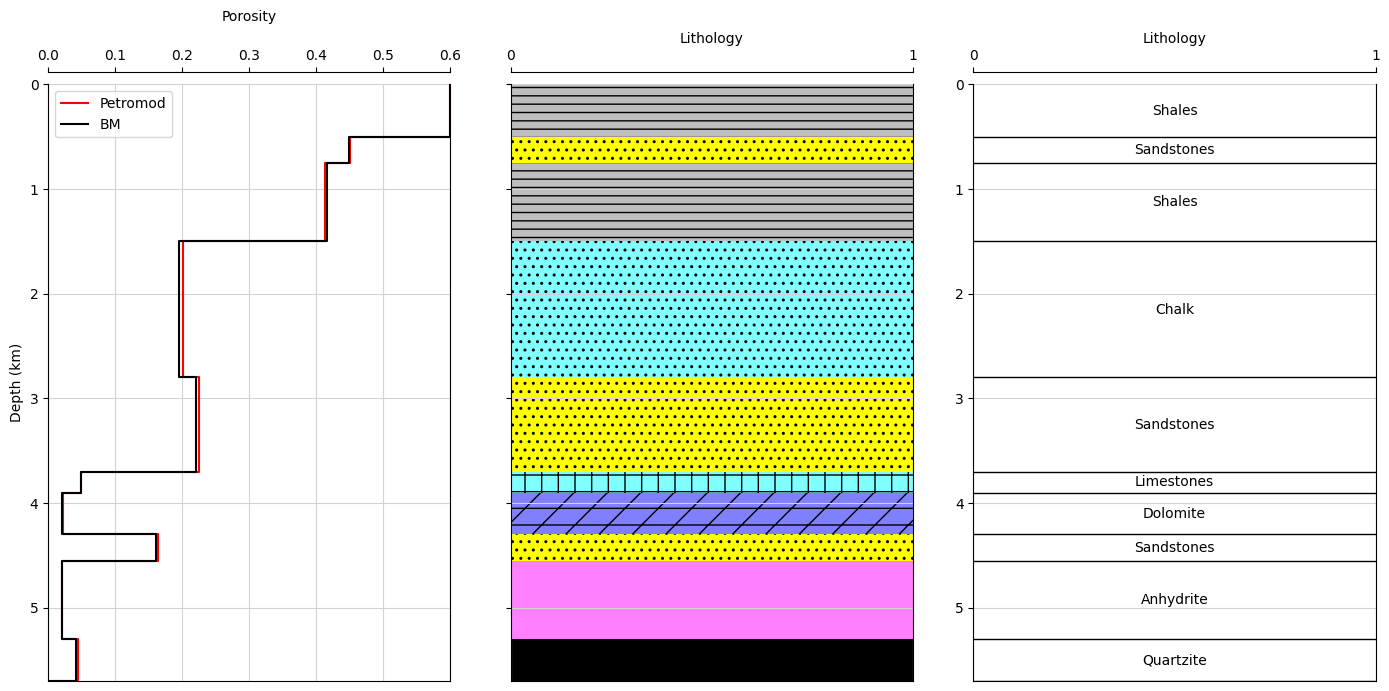

In [332]:
makeplot_porosity(porosity_df, 0, max(decompaction_corrected_df['0']))

### Tectonic driving subsidence [A58.7]

In [333]:
### Tectonic driving subsidence [A58.7]
RoWater, RoMantle = 1000, 3300
# y = tectonic_subsidence(RoMantle, RoWater, density_column, thicknesses)

# decompaction_corrected_df.iloc[2:]
thicknesses = decompaction_corrected_df.iloc[:, 2:decompaction_corrected_df.shape[1]]
density_column_test = density_column_df.iloc[:, 2:density_column_df.shape[1]]

# density_column_test.shape, thicknesses.shape


# Initialize an empty list to store the output values
output_values = []
col_name = list(df_well['Age (Ma)'][1:])[::-1]
print(len(col_name))


for columns2, column_name in zip(thicknesses.columns, density_column_test.columns):
  y = tectonic_subsidence(RoMantle, RoWater,
                          density_column_test[column_name].values,
                          thicknesses[columns2].values)
  output_values.append(y)

output_df = pd.DataFrame(output_values).T[::-1].rename(columns=dict(enumerate(col_name)))
output_df

11


,260,245,210,160,145,125,100,80,55,45,0
9,0.048783,0.196275,0.324557,0.563523,0.683447,0.751489,1.346034,2.002260,2.177413,2.188169,2.23896
8,0.000000,0.000000,0.206856,0.411824,0.542790,0.605545,1.182022,1.836816,2.017534,2.030822,2.08184
7,0.000000,0.000000,0.005231,0.147981,0.294551,0.345952,0.883055,1.528742,1.718372,1.736065,1.78724
6,0.000000,0.000000,0.000000,0.013293,0.179004,0.230643,0.767320,1.422240,1.617568,1.637339,1.68904
5,0.000000,0.000000,0.000000,0.000000,0.025108,0.074658,0.600330,1.256647,1.457685,1.479994,1.53192
4,0.000000,0.000000,0.000000,0.000000,0.000000,-0.027347,0.508703,1.172505,1.377392,1.401171,1.45336
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033612,0.779754,1.012036,1.044694,1.09984
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064106,0.464643,0.522174,0.58920
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110894,0.207851,0.29460
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105131,0.19640


Fig. A58.2 Tectonic subsidence Y after decompaction and
backstripping.

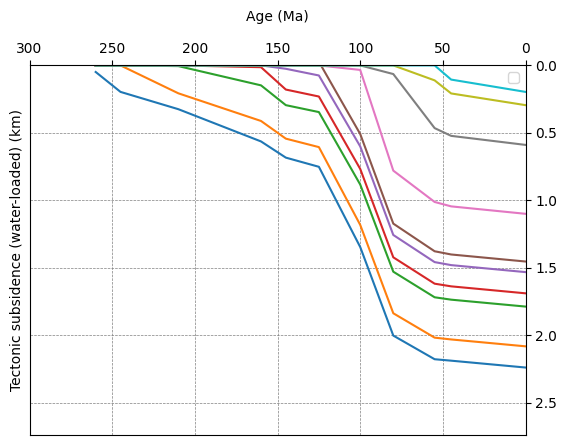

In [334]:
# work_layers = decompaction_corrected_df.drop(['Lithology_type', 'Event_name'], axis=1, inplace=False)
# age_values = [int(age.split(' Ma')[0]) for age in work_layers.columns.tolist()]
age_values  = [int(age) for age in df_well['Age (Ma)'][1:]][::-1]
# age_values = list(df_well['Age (Ma)'][1:])[::-1]

# work_layers_copy = work_layers.copy()

# # Plot the lines for each row in work_layers_copy
for row_index, row in output_df.iterrows():
    plt.plot(age_values, row.values)

# # Calculate sea level and sea level today
# sea_level = df_well[1:df_well.shape[0]]['Paleobathymetry, Ma'] / 1000
# sea_level_today = df_well[1:df_well.shape[0]]['Sea level, m'] / 1000

# # Plot sea level and present-day sea level
# plt.plot(age_values, (abs(sea_level - sea_level_today))[::-1], 'k--', label='Sea level')
# plt.plot(age_values, np.zeros(work_layers_copy.shape[1]), 'k--', label='present-day sea level')

# # Fill the space between the two sea level plots with blue color
# plt.fill_between(age_values, np.zeros(work_layers_copy.shape[1]),
#  (abs(sea_level - sea_level_today))[::-1], color='blue', alpha=0.2, label='Sea level' )

# Additional plotting settings
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Age (Ma)', labelpad=20)
plt.ylabel(f'Tectonic subsidence (water-loaded) (km)')
plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

In [336]:
def highlight_value(s):
    return ['background-color: red; color: white' if v < 0 else 'background-color: red; color: white' if v > 0 else '' for v in s]

styled_df = result.style.apply(highlight_value)
styled_df

NameError: name 'result' is not defined

### 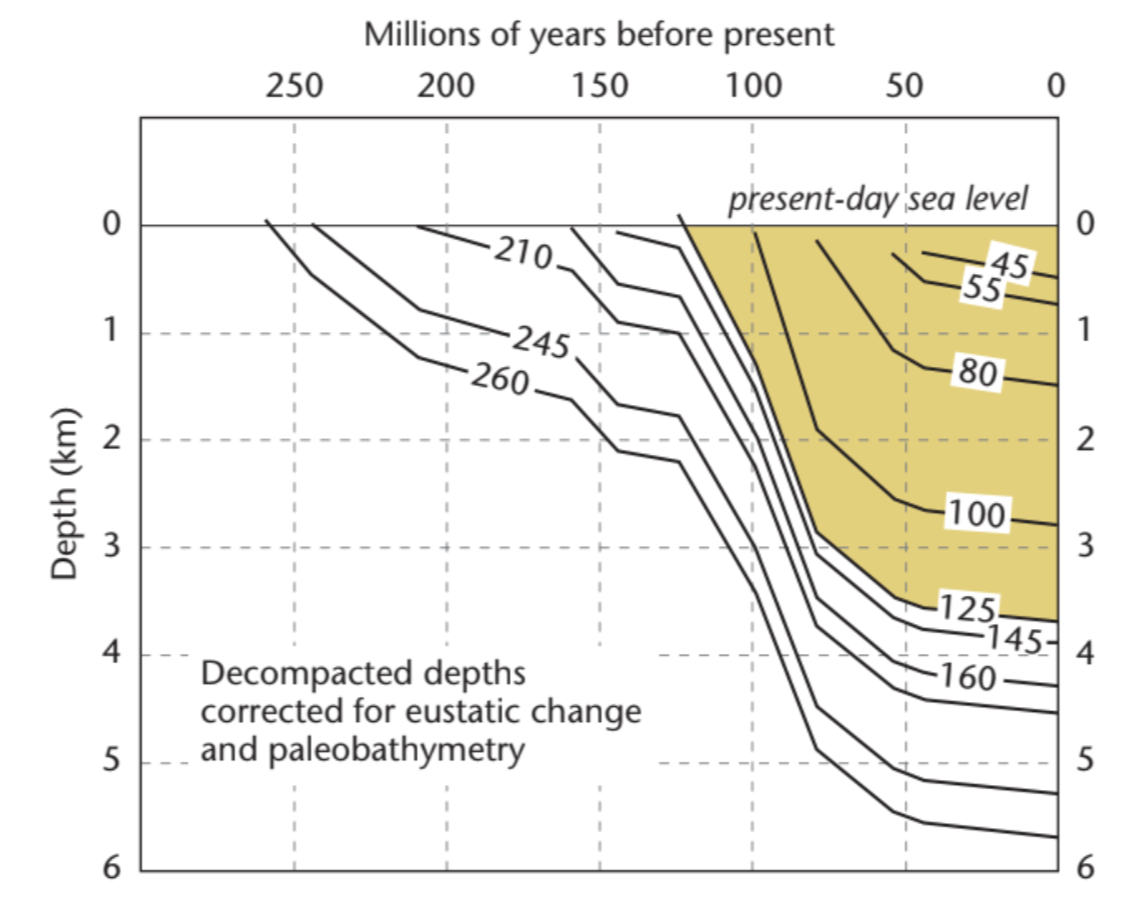Plots Age - Corrected decompacted depth

In [337]:
# Data referenve Petromod
data_ref = pd.read_excel('/content/Charts (1).xlsx', sheet_name='Petromod depth', skiprows=0, header=0, engine='openpyxl')
data_ref = data_ref.applymap(lambda x: x.split('\t') if isinstance(x, str) else x)

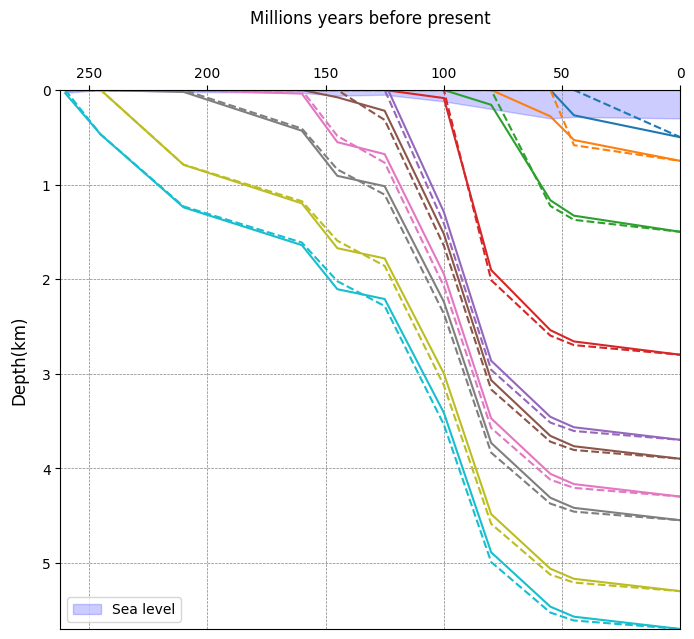

<Figure size 640x480 with 0 Axes>

In [338]:
plt.figure(figsize=(8, 7))

    # Our data
work_layers = decompaction_corrected_df.drop(['Lithology_type', 'Event_name'], axis=1, inplace=False)
age_values = [int(age.split(' Ma')[0]) for age in work_layers.columns.tolist()]
work_layers_copy = work_layers.copy()

# Plot the lines for each row in work_layers_copy
for row_index, row in work_layers_copy.iterrows():
  plt.plot(age_values, row.values, linestyle='solid')

    # Petromode
work_layers = data_ref.drop(['Unnamed: 0', 'Lithology_type', 'Event_name'], axis=1, inplace=False)
work_layers_copy = work_layers.copy()

for row_index, row in work_layers_copy.iterrows():
  plt.plot(age_values, row.values, linestyle='dashed')

# Calculate sea level and sea level today
sea_level = df_well[1:df_well.shape[0]]['Paleobathymetry, Ma'] / 1000
sea_level_today = df_well[1:df_well.shape[0]]['Sea level, m'] / 1000

# # Plot sea level and present-day sea level
# plt.plot(age_values, (abs(sea_level - sea_level_today))[::-1], 'k--', label='Sea level')
# plt.plot(age_values, np.zeros(work_layers_copy.shape[1]), 'k--', label='present-day sea level')

# Fill the space between the two sea level plots with blue color
plt.fill_between(age_values, np.zeros(work_layers_copy.shape[1]),
 (abs(sea_level - sea_level_today))[::-1], color='blue', alpha=0.2, label='Sea level' )

# Additional plotting settings
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(work_layers_copy), -1])
plt.axis([262, 0, np.max(work_layers_copy), 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Millions years before present', labelpad=10, fontsize=12)
plt.ylabel(f'Depth(km)', labelpad=10, fontsize=12)
plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend(loc='lower left')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()
plt.savefig("age-depth.png")

### Step4. Thermal conductivity of the basin-fill

In [339]:
def bulk_thermal_conductivity(tc_matrix, tc_includion, porosity):
  return tc_matrix*(1-porosity) + tc_includion*porosity

In [340]:
def geotherm_constant_heat(surface_T, basal_HF, depth, tc_bulk):
  return surface_T + (-basal_HF*depth * tc_bulk**-1)

In [341]:
work_layers = df_well[1:df_well.shape[0]-1] ### Слои, по которым идет расчет
work_layers

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
1,Test_well,Layer 10,Erosion,Shales,0,0.00,0.20,200,NaN,300,0,1,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstones,45,0.20,0.45,250,NaN,325,40,1,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shales,55,0.45,1.20,750,NaN,350,50,1,Reservoir,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk,80,1.20,2.50,1300,NaN,300,100,1,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstones,100,2.50,3.40,900,NaN,200,80,1,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestones,125,3.40,3.60,200,NaN,20,70,10,NaN,NaN,NaN,NaN
7,Test_well,Layer 4,Deposition,Dolomite,145,3.60,4.00,400,NaN,20,-40,1,Reservoir,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstones,160,4.00,4.25,250,NaN,10,-20,1,NaN,NaN,NaN,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,10,NaN,NaN,NaN,NaN
10,Test_well,Layer 1,Deposition,Quartzite,245,5.00,5.40,400,NaN,0,0,1,NaN,NaN,NaN,NaN


In [342]:
tc_bulk_df = pd.DataFrame()

age_list = list(df_well['Age (Ma)'][1:])
print(age_list)

for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    tc_bulk_list = []

    # thinkness_list = []
    # thinkness_corrected_list = []
    # porosity_average_list = []
    # porosity_test = []
    # density_list = []
    # density_column = []
    # density_column_total = []

    RoWater, RoMantle = 1000, 3300
    tc_water = 0.60
    sea_level = df_well.loc[df_well['Age (Ma)'] == int(age), 'Paleobathymetry, Ma'].iloc[0]/1000
    sea_level_today = df_well.loc[df_well['Age (Ma)'] == int(age), 'Sea level, m'].iloc[0]/1000

    print('Age', age)

    ### расчет corrected_decompaction for Fundament (not in work_layer)
    if int(age) == age_list[-1]:
          tc_bulk = 0
          tc_bulk_list.append(tc_bulk)


### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      phi0 = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Porosity'].iloc[0]
      tc_matrix = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'TC matrix'].iloc[0]

      # c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
      # RoGrain = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Grain density'].iloc[0]
      # y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      # y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

### Bulk thermal conductivity
      tc_bulk = bulk_thermal_conductivity(tc_matrix, tc_water, phi0)
      tc_bulk_list.append(tc_bulk)
      print(row_index, lithology, layers_name, phi0, np.round(bulk_thermal_conductivity(tc_matrix, tc_water, phi0), 2))


### Save results in table
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(tc_bulk_list):] = tc_bulk_list
    new_col_values = resized_list_new
    tc_bulk_df[new_col_name] = new_col_values

[0, 45, 55, 80, 100, 125, 145, 160, 210, 245, 260]
Age 0
0 Shales Layer 10 0.63 1.12
1 Sandstones Layer 9 0.49 3.1
2 Shales Layer 8 0.63 1.12
3 Chalk Layer 7 0.7 1.41
4 Sandstones Layer 6 0.49 3.1
5 Limestones Layer 5 0.4 2.22
6 Dolomite Layer 4 0.2 4.36
7 Sandstones Layer 3 0.49 3.1
8 Anhydrite Layer 2 0.05 6.02
9 Quartzite Layer 1 0.2 6.28
Age 45
1 Sandstones Layer 9 0.49 3.1
2 Shales Layer 8 0.63 1.12
3 Chalk Layer 7 0.7 1.41
4 Sandstones Layer 6 0.49 3.1
5 Limestones Layer 5 0.4 2.22
6 Dolomite Layer 4 0.2 4.36
7 Sandstones Layer 3 0.49 3.1
8 Anhydrite Layer 2 0.05 6.02
9 Quartzite Layer 1 0.2 6.28
Age 55
2 Shales Layer 8 0.63 1.12
3 Chalk Layer 7 0.7 1.41
4 Sandstones Layer 6 0.49 3.1
5 Limestones Layer 5 0.4 2.22
6 Dolomite Layer 4 0.2 4.36
7 Sandstones Layer 3 0.49 3.1
8 Anhydrite Layer 2 0.05 6.02
9 Quartzite Layer 1 0.2 6.28
Age 80
3 Chalk Layer 7 0.7 1.41
4 Sandstones Layer 6 0.49 3.1
5 Limestones Layer 5 0.4 2.22
6 Dolomite Layer 4 0.2 4.36
7 Sandstones Layer 3 0.49 3.1
8 An

In [343]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
tc_bulk_df['Event_name'] = work_layers['Event_name']
tc_bulk_df['Lithology_type'] = work_layers['Lithology_type']
tc_bulk_df= tc_bulk_df[tc_bulk_df.columns[::-1]]

tc_bulk_df.to_csv('/content/TC_bulk.csv', index=True)

In [344]:
tc_bulk_df

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.118
1,Sandstones,Layer 9,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.099,3.099
2,Shales,Layer 8,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,1.118,1.118,1.118
3,Chalk,Layer 7,0.0,0.00,0.000,0.000,0.000,0.000,0.000,1.410,1.410,1.410,1.410
4,Sandstones,Layer 6,0.0,0.00,0.000,0.000,0.000,0.000,3.099,3.099,3.099,3.099,3.099
5,Limestones,Layer 5,0.0,0.00,0.000,0.000,0.000,2.220,2.220,2.220,2.220,2.220,2.220
6,Dolomite,Layer 4,0.0,0.00,0.000,0.000,4.360,4.360,4.360,4.360,4.360,4.360,4.360
7,Sandstones,Layer 3,0.0,0.00,0.000,3.099,3.099,3.099,3.099,3.099,3.099,3.099,3.099
8,Anhydrite,Layer 2,0.0,0.00,6.015,6.015,6.015,6.015,6.015,6.015,6.015,6.015,6.015
9,Quartzite,Layer 1,0.0,6.28,6.280,6.280,6.280,6.280,6.280,6.280,6.280,6.280,6.280


### Step 5. Calculation of the geotherm with variable thermal conductivity (a constant heat flow from the mantle)

In [345]:
def geotherm_constant_heat(surface_T, basal_HF, depth, tc_bulk):
    result = []
    for d, tc in zip(depth, tc_bulk):
        if np.any(tc_bulk == 0) and tc == 0:
            result.append(0)
        else:
          T = surface_T + (-basal_HF * d * 1/(tc))
          result.append(T)
    return result

In [346]:
surface_T = 0
basal_HF = -63

depth = decompaction_df.iloc[:, 2:decompaction_df.shape[1]]
tc = tc_bulk_df.iloc[:, 2:tc_bulk_df.shape[1]]

# Initialize an empty DataFrame to store the output values
geothermal_constant = pd.DataFrame()

for column_depth, column_tc in zip(depth.columns, tc.columns):
    T = geotherm_constant_heat(surface_T, basal_HF, depth[column_depth].values, tc[column_tc].values)
    geothermal_constant[column_depth] = T

In [347]:
geothermal_constant

,260,245,210,160,145,125,100,80,55,45,0
0,0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.270125
1,0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.305905,5.082285
2,0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.039356,45.080501,42.262970
3,0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,78.057447,61.391489,59.425532,58.085106
4,0,0.000,0.000000,0.000000,0.000000,0.000000,24.496612,19.495644,18.641820,18.438529,18.296225
5,0,0.000,0.000000,0.000000,0.000000,8.513514,6.583784,5.817568,5.704054,5.704054,5.675676
6,0,0.000,0.000000,0.000000,6.849083,6.632339,6.112156,5.837615,5.794266,5.794266,5.779817
7,0,0.000,0.000000,7.969022,7.237173,6.891578,5.956438,5.285576,5.143272,5.102614,5.082285
8,0,0.000,8.075312,8.043890,8.012469,8.001995,7.939152,7.876309,7.865835,7.855362,7.855362
9,0,4.725,4.514331,4.434076,4.353822,4.303662,4.173248,4.052866,4.022771,4.022771,4.012739


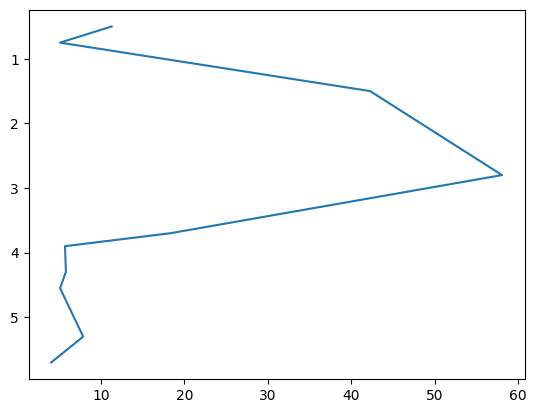

In [348]:
plt.plot(geothermal_constant['0'],decompaction_corrected_df['0'])
plt.gca().invert_yaxis()

In [349]:
tc_bulk_df

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.118
1,Sandstones,Layer 9,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.099,3.099
2,Shales,Layer 8,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,1.118,1.118,1.118
3,Chalk,Layer 7,0.0,0.00,0.000,0.000,0.000,0.000,0.000,1.410,1.410,1.410,1.410
4,Sandstones,Layer 6,0.0,0.00,0.000,0.000,0.000,0.000,3.099,3.099,3.099,3.099,3.099
5,Limestones,Layer 5,0.0,0.00,0.000,0.000,0.000,2.220,2.220,2.220,2.220,2.220,2.220
6,Dolomite,Layer 4,0.0,0.00,0.000,0.000,4.360,4.360,4.360,4.360,4.360,4.360,4.360
7,Sandstones,Layer 3,0.0,0.00,0.000,3.099,3.099,3.099,3.099,3.099,3.099,3.099,3.099
8,Anhydrite,Layer 2,0.0,0.00,6.015,6.015,6.015,6.015,6.015,6.015,6.015,6.015,6.015
9,Quartzite,Layer 1,0.0,6.28,6.280,6.280,6.280,6.280,6.280,6.280,6.280,6.280,6.280


## A58.10

In [ ]:
depth = decompaction_df.iloc[0:decompaction_df.shape[0]-1,2:decompaction_df.shape[1]]
tc = tc_bulk_df.iloc[:, 2:tc_bulk_df.shape[1]]

surface_T = 0
basal_HF = -30

new_tab = depth/tc

table2 = pd.DataFrame()
table3 = pd.DataFrame()

for col in new_tab.columns:
    cumulative_sum = new_tab[col].cumsum()
    table2[col] = surface_T+ (-basal_HF*cumulative_sum)

### проверка по глубине
for col in depth.columns:
    check_y = depth[col].cumsum
    table3[col] = depth[col].cumsum()

In [350]:
table2

,260,245,210,160,145,125,100,80,55,45,0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.366726
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.526621,7.786862
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.828265,23.993527,27.912085
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.170213,53.062307,52.291399,55.571660
4,NaN,NaN,NaN,NaN,NaN,NaN,11.665053,46.453853,61.939364,61.071651,64.284148
5,NaN,NaN,NaN,NaN,NaN,4.054054,14.800188,49.224123,64.655581,63.787867,66.986851
6,NaN,NaN,NaN,NaN,3.261468,7.212311,17.710739,52.003939,67.414755,66.547041,69.739144
7,NaN,NaN,NaN,3.794773,6.707741,10.494015,20.547138,54.520880,69.863932,68.976857,72.159280
8,NaN,NaN,3.845387,7.625196,10.523202,14.304489,24.327686,58.271504,73.609568,72.717506,75.899928
9,NaN,2.25,5.995068,9.736661,12.596451,16.353852,26.314947,60.201440,75.525173,74.633111,77.810756


In [351]:
table3

,260,245,210,160,145,125,100,80,55,45,0
0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.20
1,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.261,0.45
2,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.888,1.061,1.20
3,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.747,2.262,2.391,2.50
4,0.0,0.000,0.000,0.000,0.000,0.000,1.205,2.706,3.179,3.298,3.40
5,0.0,0.000,0.000,0.000,0.000,0.300,1.437,2.911,3.380,3.499,3.60
6,0.0,0.000,0.000,0.000,0.474,0.759,1.860,3.315,3.781,3.900,4.00
7,0.0,0.000,0.000,0.392,0.830,1.098,2.153,3.575,4.034,4.151,4.25
8,0.0,0.000,0.771,1.160,1.595,1.862,2.911,4.327,4.785,4.901,5.00
9,0.0,0.471,1.221,1.602,2.029,2.291,3.327,4.731,5.186,5.302,5.40


In [ ]:
decompaction_corrected_df

In [ ]:
plt.plot(table2['0'],decompaction_corrected_df['0'])
plt.gca().invert_yaxis()

In [ ]:
df_constast

In [353]:
decompaction_df.loc[:].iloc[0]

Lithology_type      Shales
Event_name        Layer 10
260                    0.0
245                    0.0
210                    0.0
160                    0.0
145                    0.0
125                    0.0
100                    0.0
80                     0.0
55                     0.0
45                     0.0
0                      0.2
Name: 0, dtype: object

In [372]:
test = decompaction_corrected_df.drop(['Lithology_type', 'Event_name'], axis=1, inplace=False)
test = test['0'].tail(1).iloc[0]
test

5.699999999999999

## Step 6. The radiogenic heat contribution: Eqn. [A58.10]


In [453]:
T_with_rad_heat = pd.DataFrame()
T_without_rad_heat = pd.DataFrame()

age_list = list(df_well['Age (Ma)'][1:])
# age_list = list(df_well['Age (Ma)'][8:11])
print(age_list)

for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    T_list = []
    T_list_constant = []

    Qm = -63*10**-3
    T0 = 20

    print('Age', age)

    # ### расчет corrected_decompaction for Fundament (not in work_layer)
    # if int(age) == age_list[-1]:
    #       T = 0
    #       T_list.append(T)
    #       T_list_constant.append(T)

    sum_variables_1, sum_variables_2 = [], []
    sum_variables_3 = []


### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      A = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Radiogenic Heat Production'].iloc[0]

      K = tc_bulk_df.loc[row_index:].loc[tc_bulk_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]

      work_layers_y = decompaction_df.drop(['Lithology_type'], axis=1, inplace=False)
      y = work_layers_y[f'{age}'].tail(1).iloc[0]

      l = decompaction_df.loc[row_index:].loc[decompaction_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]

### with radio heat
      if K == 0:
        sum_variables_1.append(0)
        sum_variables_2.append(0)
      else:
        # sum_variables_1.append((Qm+A*y)*l/K)
        sum_variables_1.append(((-Qm+A*y*1000)/K)*l*1000)
        sum_variables_2.append((A/(2*K))*(l*1000)**2)

      T = T0 + (sum(sum_variables_1) - sum(sum_variables_2))
      T_list.append(T)


### without radio heat
      if K == 0:
        sum_variables_3.append(0)
      else:
        sum_variables_3.append(l*1000/K)

      T_no_heat = T0 - Qm*sum(sum_variables_3)
      T_list_constant.append(T_no_heat)

      print(row_index, lithology, layers_name, y, l, K)


### Save results in table

### with radio heat
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_with_rad_heat[new_col_name] = new_col_values

### without radio heat
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_list_constant
    new_col_values = resized_list_new
    T_without_rad_heat[new_col_name] = new_col_values



[0, 45, 55, 80, 100, 125, 145, 160, 210, 245, 260]
Age 0
0 Shales Layer 10 5.4 0.2 1.1179999999999999
1 Sandstones Layer 9 5.4 0.25 3.099
2 Shales Layer 8 5.4 0.75 1.1179999999999999
3 Chalk Layer 7 5.4 1.3 1.4100000000000001
4 Sandstones Layer 6 5.4 0.9 3.099
5 Limestones Layer 5 5.4 0.2 2.2199999999999998
6 Dolomite Layer 4 5.4 0.4 4.36
7 Sandstones Layer 3 5.4 0.25 3.099
8 Anhydrite Layer 2 5.4 0.75 6.015
9 Quartzite Layer 1 5.4 0.4 6.28
Age 45
1 Sandstones Layer 9 5.302 0.261 3.099
2 Shales Layer 8 5.302 0.8 1.1179999999999999
3 Chalk Layer 7 5.302 1.33 1.4100000000000001
4 Sandstones Layer 6 5.302 0.907 3.099
5 Limestones Layer 5 5.302 0.201 2.2199999999999998
6 Dolomite Layer 4 5.302 0.401 4.36
7 Sandstones Layer 3 5.302 0.251 3.099
8 Anhydrite Layer 2 5.302 0.75 6.015
9 Quartzite Layer 1 5.302 0.401 6.28
Age 55
2 Shales Layer 8 5.186000000000001 0.888 1.1179999999999999
3 Chalk Layer 7 5.186000000000001 1.374 1.4100000000000001
4 Sandstones Layer 6 5.186000000000001 0.917 3.099


In [454]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
T_with_rad_heat['Event_name'] = work_layers['Event_name']
T_with_rad_heat['Lithology_type'] = work_layers['Lithology_type']
T_with_rad_heat = T_with_rad_heat[T_with_rad_heat.columns[::-1]]

T_with_rad_heat.to_csv('/content/T_with_rad_heat.csv', index=True)

In [455]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
T_without_rad_heat['Event_name'] = work_layers['Event_name']
T_without_rad_heat['Lithology_type'] = work_layers['Lithology_type']
T_without_rad_heat = T_without_rad_heat[T_without_rad_heat.columns[::-1]]

T_without_rad_heat.to_csv('/content/T_without_rad_heat.csv', index=True)

In [456]:
T_with_rad_heat

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.881932
1,Sandstones,Layer 9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.828562,38.474865
2,Shales,Layer 8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,76.442328,76.872140,86.468492
3,Chalk,Layer 7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.969235,139.587471,138.047235,146.305372
4,Sandstones,Layer 6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,45.767869,121.043654,159.907942,158.188605,166.326669
5,Limestones,Layer 5,0.0,0.000000,0.000000,0.000000,0.000000,28.658176,52.519435,127.074925,165.842218,164.128133,172.241083
6,Dolomite,Layer 4,0.0,0.000000,0.000000,0.000000,26.927010,35.377325,58.752495,133.080404,171.819896,170.110078,178.211725
7,Sandstones,Layer 3,0.0,0.000000,0.000000,28.182440,34.419345,42.547388,65.069780,138.829197,177.458832,175.715809,183.804659
8,Anhydrite,Layer 2,0.0,0.000000,28.086021,36.241882,42.452755,50.573631,73.046082,146.759953,185.384729,183.632605,191.722676
9,Quartzite,Layer 1,0.0,24.733831,32.636037,40.724557,46.869188,54.948218,77.322635,150.958498,189.566670,187.818250,195.901020


In [457]:
 T_without_rad_heat

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.270125
1,Sandstones,Layer 9,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.305905,36.352410
2,Shales,Layer 8,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.039356,70.386406,78.615379
3,Chalk,Layer 7,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,98.057447,131.430845,129.811938,136.700486
4,Sandstones,Layer 6,0.0,0.000,0.000000,0.000000,0.000000,0.000000,44.496612,117.553091,150.072665,148.250466,154.996710
5,Limestones,Layer 5,0.0,0.000,0.000000,0.000000,0.000000,28.513514,51.080396,123.370658,155.776719,153.954521,160.672386
6,Dolomite,Layer 4,0.0,0.000,0.000000,0.000000,26.849083,35.145853,57.192552,129.208273,161.570985,159.748787,166.452203
7,Sandstones,Layer 3,0.0,0.000,0.000000,27.969022,34.086256,42.037431,63.148989,134.493849,166.714257,164.851400,171.534487
8,Anhydrite,Layer 2,0.0,0.000,28.075312,36.012913,42.098725,50.039426,71.088141,142.370158,174.580093,172.706762,179.389849
9,Quartzite,Layer 1,0.0,24.725,32.589643,40.446989,46.452546,54.343088,75.261390,146.423024,178.602864,176.729533,183.402588


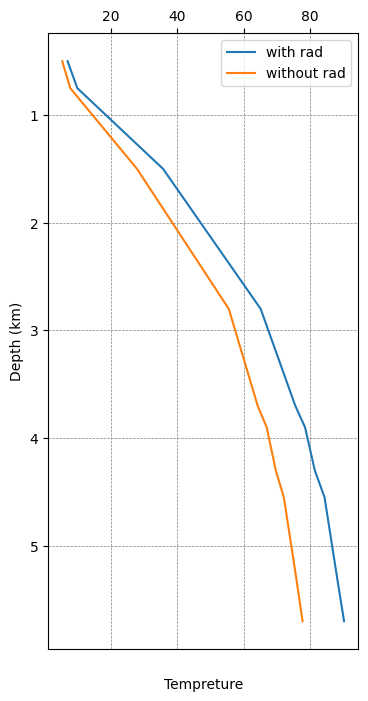

In [448]:
plt.figure(figsize=(4, 8))
plt.plot(T_with_rad_heat['0'],decompaction_corrected_df['0'], label='with rad')
plt.plot( T_without_rad_heat['0'],decompaction_corrected_df['0'], label='without rad')
plt.gca().invert_yaxis()

# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Tempreture', labelpad=20)
plt.ylabel(f'Depth (km)')
# plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# plt.xlim(0, 180)
plt.show()

In [436]:
lithology_numbers = {30000: {'lith':'Sandstones', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                 65030: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                 65000: {'lith':'Shales', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
                 80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                 74000: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
                 70000: {'lith':'Limestones', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                 70032: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                 88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                 86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'', 'color':'#ff80ff'},
                 99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                 90000: {'lith':'Quartzite', 'lith_num':11, 'hatch':'', 'color':'black'},
                 93000: {'lith':'Basement', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

In [437]:
T_with_rad_heat["Lithology"] = ['65000', '30000', '65000', '70032', '30000', '70000', '74000', '30000', '86000', '90000']
T_with_rad_heat["Lithology"] = T_with_rad_heat["Lithology"].astype(int)

In [438]:
T_with_rad_heat["Lithology"] = T_with_rad_heat["Lithology"].astype(int)

In [439]:
T_with_rad_heat

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0,Lithology
0,Shales,Layer 10,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.881932,65000
1,Sandstones,Layer 9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.828562,18.474865,30000
2,Shales,Layer 8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56.442328,56.872140,66.468492,65000
3,Chalk,Layer 7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,79.969235,119.587471,118.047235,126.305372,70032
4,Sandstones,Layer 6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,25.767869,101.043654,139.907942,138.188605,146.326669,30000
5,Limestones,Layer 5,0.0,0.000000,0.000000,0.000000,0.000000,8.658176,32.519435,107.074925,145.842218,144.128133,152.241083,70000
6,Dolomite,Layer 4,0.0,0.000000,0.000000,0.000000,6.927010,15.377325,38.752495,113.080404,151.819896,150.110078,158.211725,74000
7,Sandstones,Layer 3,0.0,0.000000,0.000000,8.182440,14.419345,22.547388,45.069780,118.829197,157.458832,155.715809,163.804659,30000
8,Anhydrite,Layer 2,0.0,0.000000,8.086021,16.241882,22.452755,30.573631,53.046082,126.759953,165.384729,163.632605,171.722676,86000
9,Quartzite,Layer 1,0.0,4.733831,12.636037,20.724557,26.869188,34.948218,57.322635,130.958498,169.566670,167.818250,175.901020,90000


In [440]:
df_lith = pd.DataFrame.from_dict(lithology_numbers, orient='index')
df_lith.index.name = 'LITHOLOGY'
df_lith

,lith,lith_num,hatch,color
LITHOLOGY,,,,
30000,Sandstones,1,..,#ffff00
65030,Sandstone/Shale,2,-.,#ffe119
65000,Shales,3,--,#bebebe
80000,Marl,4,,#7cfc00
74000,Dolomite,5,-/,#8080ff
70000,Limestones,6,+,#80ffff
70032,Chalk,7,..,#80ffff
88000,Halite,8,x,#7ddfbe
86000,Anhydrite,9,,#ff80ff


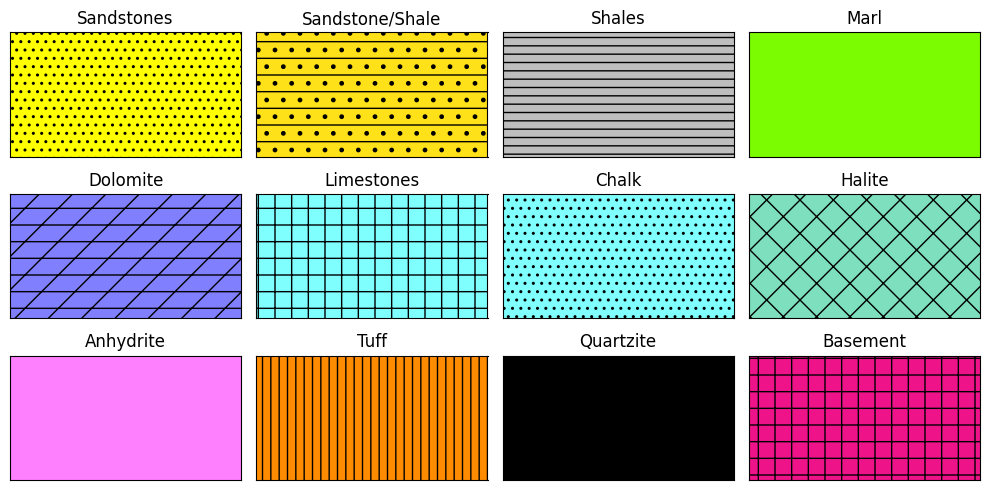

In [441]:
y = [0, 1]
x = [1, 1]

fig, axes = plt.subplots(ncols=4,nrows=3, sharex=True, sharey=True,
                         figsize=(10,5), subplot_kw={'xticks': [], 'yticks': []})

for ax, key in zip(axes.flat, lithology_numbers.keys()):
    ax.plot(x, y)
    ax.fill_betweenx(y, 0, 1, facecolor=lithology_numbers[key]['color'], hatch=lithology_numbers[key]['hatch'])
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 1)
    ax.set_title(str(lithology_numbers[key]['lith']))

plt.tight_layout()

plt.show()

In [442]:

def makeplot(well, top_depth, bottom_depth):
    # fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    # ax = fig.subplots(1, 2,  sharex=False)

    fig, ax = plt.subplots(figsize=(14,7))

    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    # ax10 = ax1.twiny()
    # ax10.xaxis.set_visible(False)

    # ax13 = ax4.twiny()
    # ax13.xaxis.set_visible(False)

### Plot 1
    # Geotherma
    ax1.plot(T_with_rad_heat['0'], decompaction_corrected_df['0'], label='with rad')
    ax1.plot(table2['0'],decompaction_corrected_df['0'], label='without rad')
    ax1.set_xlabel(f'Tempreture', labelpad=20)
    ax1.set_ylabel(f'Depth (km)')

### Plot 2
    # Lithology track
    # ax2.plot(T_with_rad_heat["Lithology"], T_with_rad_heat['depth 0'], color = "black", linewidth = 0.5)
    ax2.set_xlabel("Lithology")
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(T_with_rad_heat["Lithology"], decompaction_corrected_df['0']):
        key = int(lit)
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']

        depth_values = [depth_start, depth]
        depth_start = depth

        ax2.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch)

    ax2.set_xticks([0, 1])

### Plot3
    ax3.set_xlabel("Lithology")
    ax3.set_xlim(0, 1)
    ax3.xaxis.label.set_color("black")
    ax3.tick_params(axis='x', colors="black")
    ax3.spines["top"].set_edgecolor("black")
    ax3.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(T_with_rad_heat["Lithology_type"], decompaction_corrected_df['0']):
        key = lit
        depth_values = [depth_start, depth]
        depth_start = depth

        label_position = (0.5, sum(depth_values) / 2)  # Assuming x position is at 0.5
        ax3.text(label_position[0], label_position[1], key, ha='center', va='center')
        ax3.plot([0, 1], [depth, depth], color='black', linewidth=1)  # Assuming black color and linewidth of 1



    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)

<ipython-input-442-e7a5130f738c>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)


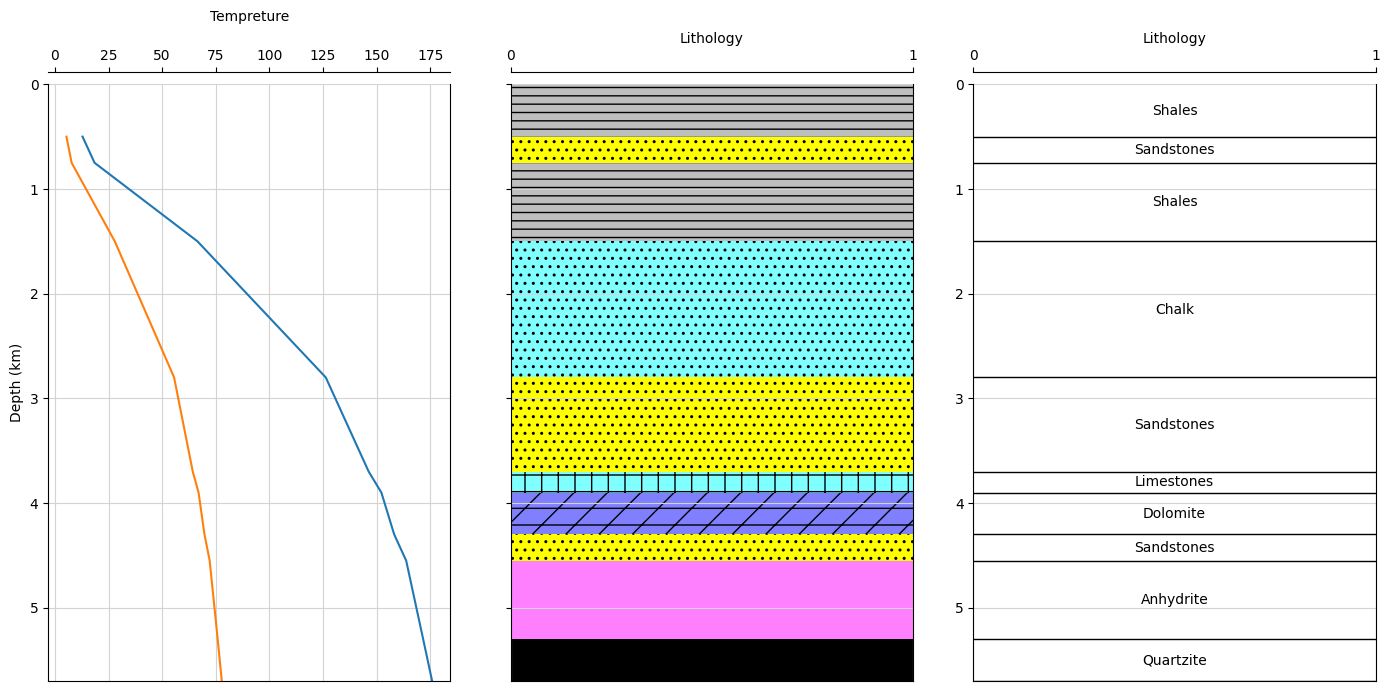

In [443]:
makeplot(T_with_rad_heat, 0, max(decompaction_corrected_df['0']))

## Step 7. Calculation of the stretch factor

In [ ]:
import warnings
from scipy import stats

warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

In [ ]:
from scipy.stats import linregress
from scipy.optimize import fsolve

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Define beta=stretch factor
def stretch_factor(beta):
  return E0 * (beta/np.pi) * np.sin(np.pi/beta) - slope


stretch_factor_df = pd.DataFrame()

tau = 50

for age in output_df.columns:
    col_list = output_df[age].tolist()
    thermal_subsidenence = col_list[::-1]
    non_zero_values = [value for value in thermal_subsidenence if value != 0]
    time = np.array(df_well['Age (Ma)'][1:len(non_zero_values)+1])

    x = 1-np.exp(-time/tau)
    y = list(map(lambda x: x * 1000, non_zero_values))

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate E0

    # Constant value - pp.497 (pdf), Table A19.1
    Tm = 1330
    yl = 125
    alpha_v =3.28*10**-5 #CLTE
    RoWater, RoMantle = 1030, 3300

    # # Example from book
    # slope, E0 = 1368, 3212

    E0 = (4*yl*RoMantle*alpha_v*Tm)/(np.pi**2*(RoMantle - RoWater))*1000 # [m]

    beta = fsolve(stretch_factor, 1.0)[0]

    # print(age, f"The value of beta is: {beta:.2f}")

    # Save results in table
    new_col_name = f'{age}'
    stretch_factor_df[new_col_name] = [beta]

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/usr/local/lib/python3.10/dist-packages/scipy/stats/

In [ ]:
stretch_factor_df.to_csv('/content/Stretch_factor.csv', index=True)

In [ ]:
stretch_factor_df

,260,245,210,160,145,125,100,80,55,45,0
0,1.0,1.0,1.13703,1.195923,1.221388,1.248331,1.454701,1.819482,1.973033,2.024558,1.981295


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


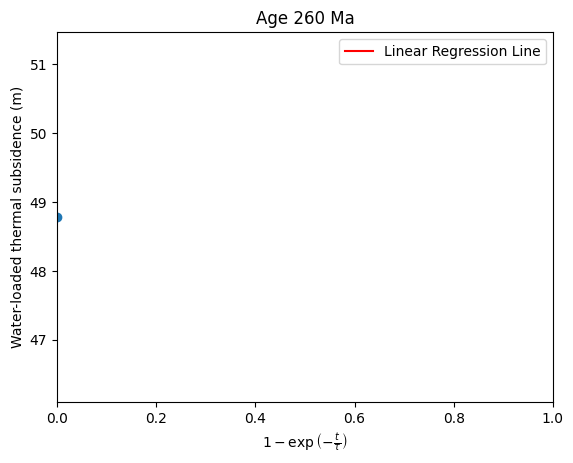

Equation of the linear regression line: y = nanx + nan
R coefficient: 0.00
Slope: nan [m]


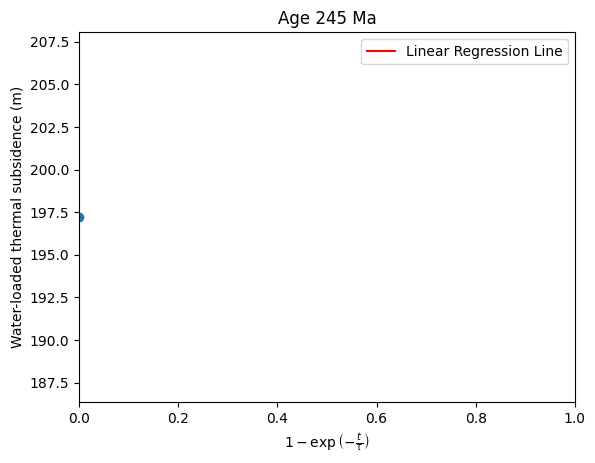

Equation of the linear regression line: y = nanx + nan
R coefficient: 0.00
Slope: nan [m]


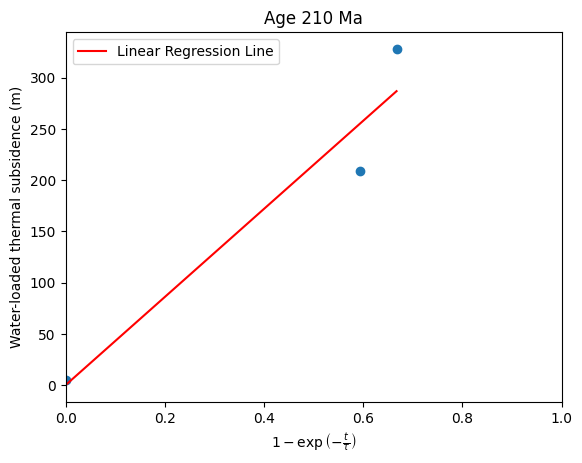

Equation of the linear regression line: y = 429.81x + 0.18
R coefficient: 0.96
Slope: 429.81 [m]


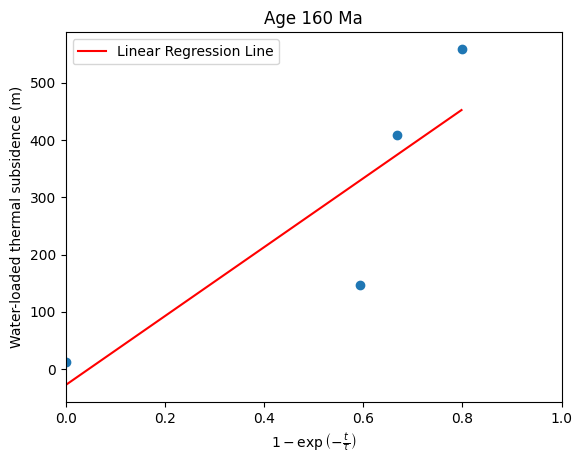

Equation of the linear regression line: y = 602.04x + -27.90
R coefficient: 0.86
Slope: 602.04 [m]


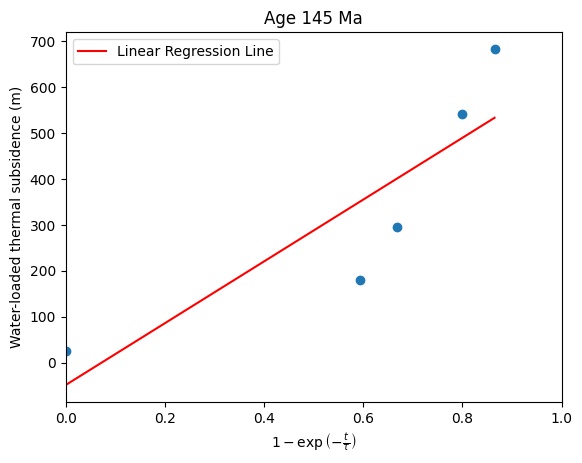

Equation of the linear regression line: y = 673.45x + -48.85
R coefficient: 0.87
Slope: 673.45 [m]


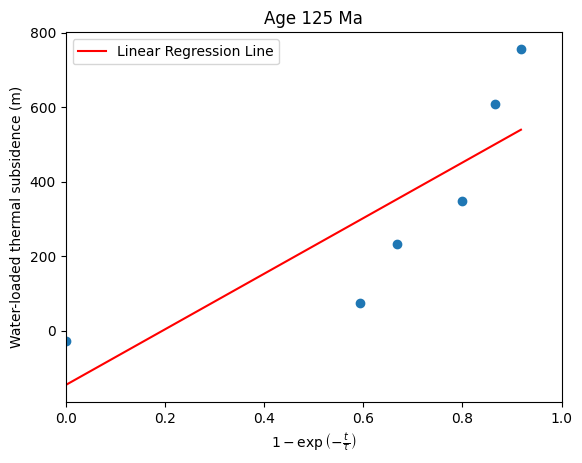

Equation of the linear regression line: y = 746.91x + -145.90
R coefficient: 0.83
Slope: 746.91 [m]


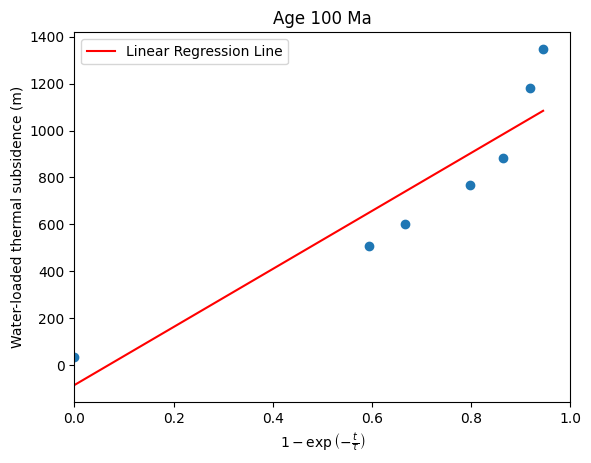

Equation of the linear regression line: y = 1237.15x + -85.06
R coefficient: 0.92
Slope: 1237.15 [m]


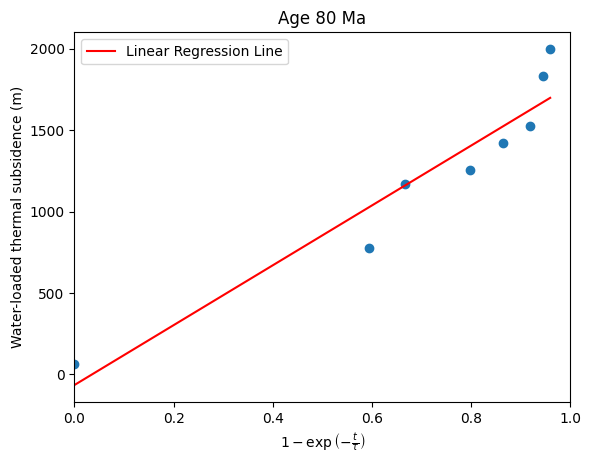

Equation of the linear regression line: y = 1838.17x + -64.94
R coefficient: 0.95
Slope: 1838.17 [m]


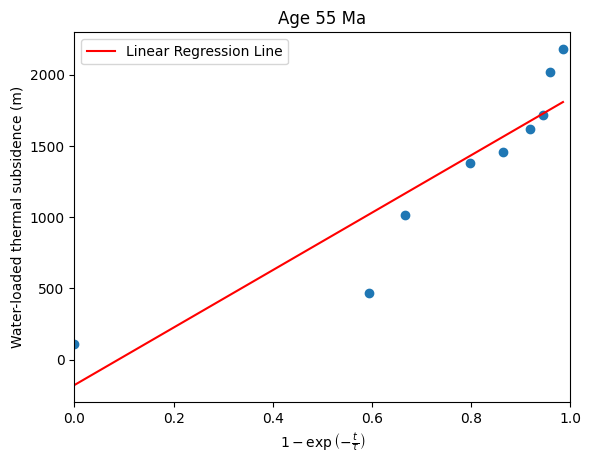

Equation of the linear regression line: y = 2017.29x + -178.40
R coefficient: 0.91
Slope: 2017.29 [m]


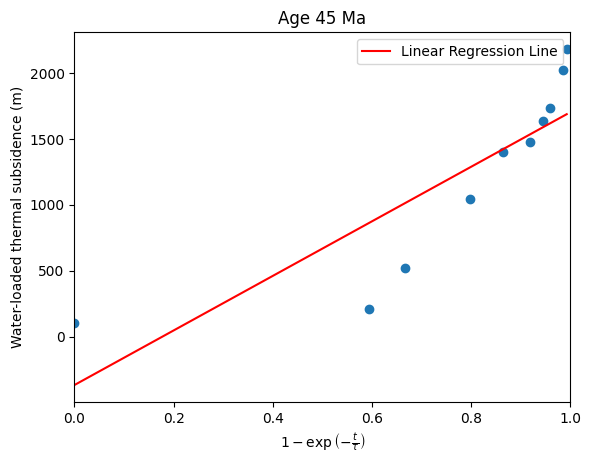

Equation of the linear regression line: y = 2070.07x + -366.88
R coefficient: 0.85
Slope: 2070.07 [m]


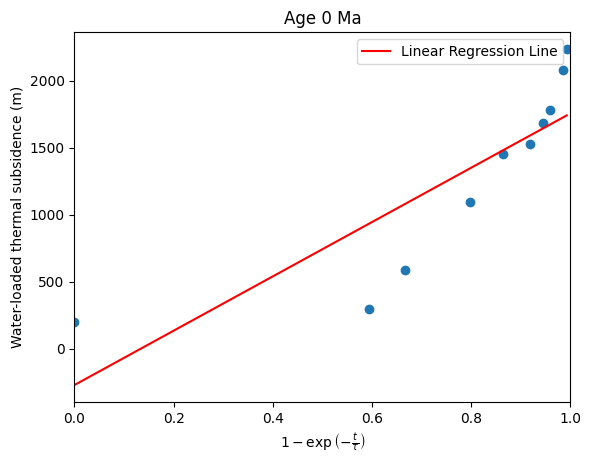

Equation of the linear regression line: y = 2025.98x + -270.49
R coefficient: 0.85
Slope: 2025.98 [m]


In [ ]:
for age in output_df.columns:
    col_list = output_df[age].tolist()
    thermal_subsidence = col_list[::-1]
    non_zero_values = [val for val in thermal_subsidence if val != 0]

    tau = 50
    time = np.array(df_well['Age (Ma)'][1:len(non_zero_values)+1])

    x = 1 - np.exp(-time/tau)
    y = list(map(lambda x: x * 1000, non_zero_values))

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the regression line
    regression_line = slope * x + intercept

    plt.scatter(x, y)
    plt.plot(x, regression_line, color='red', label='Linear Regression Line')
    plt.xlim(0, 1)
    plt.legend(loc='best')
    plt.title(f'Age {age} Ma')
    plt.xlabel(r'$1 - \exp\left(-\frac{t}{\tau}\right)$')
    plt.ylabel(r'Water-loaded thermal subsidence (m)')

    plt.show()

    # Print the equation of the linear regression line and the R coefficient
    print(f"Equation of the linear regression line: y = {slope:.2f}x + {intercept:.2f}")
    print(f"R coefficient: {r_value:.2f}")
    print(f"Slope: {slope:.2f} [m]")

## Step 8. Calculation of paleotemperatures using the reference uniform stretching model



In [ ]:
# Constant value - pp.560 (pdf)
tau = 50.2
Ks = 1.25
Kb = 3
Tm = 1330
yl = 125

In [ ]:
stretch_factor_df

,260,245,210,160,145,125,100,80,55,45,0
0,1.0,1.0,1.13703,1.195923,1.221388,1.248331,1.454701,1.819482,1.973033,2.024558,1.981295


In [ ]:
decompaction_df.iloc[0:decompaction_df.shape[0]-1, 2:decompaction_df.shape[1]]

,260,245,210,160,145,125,100,80,55,45,0
0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.20
1,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.261,0.25
2,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.888,0.800,0.75
3,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.747,1.374,1.330,1.30
4,0.0,0.000,0.000,0.000,0.000,0.000,1.205,0.959,0.917,0.907,0.90
5,0.0,0.000,0.000,0.000,0.000,0.300,0.232,0.205,0.201,0.201,0.20
6,0.0,0.000,0.000,0.000,0.474,0.459,0.423,0.404,0.401,0.401,0.40
7,0.0,0.000,0.000,0.392,0.356,0.339,0.293,0.260,0.253,0.251,0.25
8,0.0,0.000,0.771,0.768,0.765,0.764,0.758,0.752,0.751,0.750,0.75
9,0.0,0.471,0.450,0.442,0.434,0.429,0.416,0.404,0.401,0.401,0.40


In [ ]:
decompaction_corrected_df.iloc[:, 2:decompaction_corrected_df.shape[1]]

,260,245,210,160,145,125,100,80,55,45,0
0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.267609,0.50
1,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.278261,0.529083,0.75
2,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.156522,1.165901,1.329189,1.50
3,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085217,1.903843,2.539444,2.659257,2.80
4,0.000,0.000000,0.000000,0.000000,0.000000,-0.080435,1.289725,2.862782,3.456213,3.566666,3.70
5,0.000,0.000000,0.000000,0.000000,0.077391,0.219591,1.522028,3.068223,3.657687,3.767310,3.90
6,0.000,0.000000,0.000000,0.038696,0.551755,0.678387,1.945401,3.472535,4.058873,4.167828,4.30
7,0.000,0.000000,0.020000,0.430762,0.907915,1.017546,2.238826,3.732569,4.311812,4.419136,4.55
8,0.000,0.000000,0.790834,1.198791,1.673076,1.781086,2.996802,4.484763,5.062484,5.169437,5.30
9,0.034,0.471032,1.240818,1.640374,2.106633,2.210350,3.412623,4.888709,5.463658,5.569962,5.70


In [ ]:
def paleotemperatures_reference(decompacted_depth, thickness, stretch_factor, age):
  return Tm*(Kb/Ks)*(decompacted_depth/thickness) * (1+((2*stretch_factor/np.pi)*\
                                                     np.sin(np.pi/stretch_factor)*\
                                                     np.exp(-age/tau)))

In [ ]:
# Preparation dataframe of initial lithospheric thinkness at age 0 Ma

initial_thinkness = pd.DataFrame()

for i in age_list:
    col_name = f'{i}'
    initial_thinkness[col_name] = decompaction_df.iloc[0:decompaction_df.shape[0]-1, -1].tolist()

,260,245,210,160,145,125,100,80,55,45,0
0,0.20,0.20,0.20,0.20,0.20,0.20,0.20,0.20,0.20,0.20,0.20
1,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
2,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
3,1.30,1.30,1.30,1.30,1.30,1.30,1.30,1.30,1.30,1.30,1.30
4,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90
5,0.20,0.20,0.20,0.20,0.20,0.20,0.20,0.20,0.20,0.20,0.20
6,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40
7,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
8,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
9,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40


In [ ]:
# Ensure that the column names are correctly accessed using the age values\

T_paleo_df= pd.DataFrame()

age_list = list(df_well['Age (Ma)'][1:])[::-1]
corr_decompacted_depth = decompaction_corrected_df.iloc[:, 2:decompaction_corrected_df.shape[1]]

for age in age_list:

  output_values = np.zeros(corr_decompacted_depth.shape[1]-1)

  age = str(age)
  depth = corr_decompacted_depth[age]
  # thickness = initial_thinkness[age]
  thickness = yl
  # beta = stretch_factor_df[age]
  beta = 1.71

  # print(depth.values, thickness.values, beta)

  T = paleotemperatures_reference(depth.values,
                                  thickness,
                                  beta, int(age))

    # T = paleotemperatures_reference(depth.values,
    #                               thickness.values,
    #                               beta.values, int(age))

  output_values[:len(T)] = T
  T_paleo_df[age] = output_values

T_paleo_df

,260,245,210,160,145,125,100,80,55,45,0
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.762025,26.177219
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.600638,19.300278,39.265829
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.849853,40.226270,48.487117,78.531658
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.487881,58.990898,87.616645,97.006320,146.592428
4,0.000000,0.000000,0.000000,0.000000,0.000000,-2.232823,37.652899,88.703805,119.247260,130.107448,193.711423
5,0.000000,0.000000,0.000000,0.000000,2.091793,6.095733,44.434857,95.069414,126.198596,137.426671,204.182310
6,0.000000,0.000000,0.000000,1.030976,14.913271,18.831647,56.795054,107.597094,140.040404,152.037087,225.124086
7,0.000000,0.000000,0.518899,11.476873,24.539832,28.246484,65.361456,115.654294,148.767408,161.204460,238.212695
8,0.000000,0.000000,20.518140,31.939625,45.221219,49.441938,87.490181,138.961152,174.667290,188.574513,277.478524
9,0.873359,12.124197,32.192966,43.704828,56.939733,61.358049,99.629893,151.477508,188.508729,203.185125,298.420300


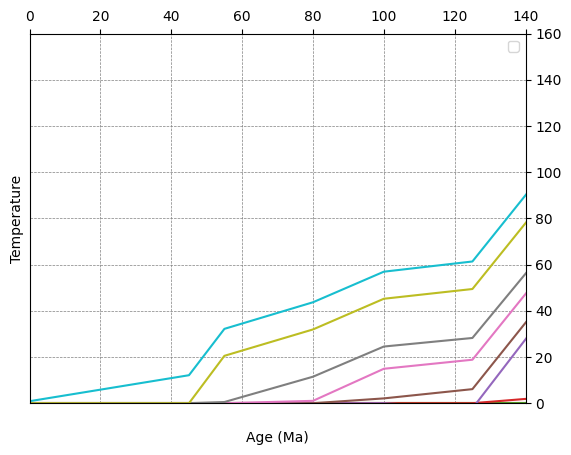

In [ ]:
# work_layers = decompaction_corrected_df.drop(['Lithology_type', 'Event_name'], axis=1, inplace=False)
# age_values = [int(age.split(' Ma')[0]) for age in work_layers.columns.tolist()]
age_values  = [int(age) for age in df_well['Age (Ma)'][1:]]
# age_values = list(df_well['Age (Ma)'][1:])[::-1]

# work_layers_copy = work_layers.copy()

# # Plot the lines for each row in work_layers_copy
for row_index, row in T_paleo_df.iterrows():
    plt.plot(age_values, row.values)

# # Calculate sea level and sea level today
# sea_level = df_well[1:df_well.shape[0]]['Paleobathymetry, Ma'] / 1000
# sea_level_today = df_well[1:df_well.shape[0]]['Sea level, m'] / 1000

# # Plot sea level and present-day sea level
# plt.plot(age_values, (abs(sea_level - sea_level_today))[::-1], 'k--', label='Sea level')
# plt.plot(age_values, np.zeros(work_layers_copy.shape[1]), 'k--', label='present-day sea level')

# # Fill the space between the two sea level plots with blue color
# plt.fill_between(age_values, np.zeros(work_layers_copy.shape[1]),
#  (abs(sea_level - sea_level_today))[::-1], color='blue', alpha=0.2, label='Sea level' )

# Additional plotting settings
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(T_paleo_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Age (Ma)', labelpad=20)
plt.ylabel(f'Temperature')
# plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlim(0, 140)
plt.ylim(0, 160)


# Display the plot
plt.show()